In [1]:
import os, sys
residual2vec_ = '../../residual2vec_'
sys.path.insert(0, residual2vec_)

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from debias_graph import debias_wrapper
from utils import graph_utils
from models import fast_knn_cpu


/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
dataset = "polbook"
# group values for each node
y = pd.read_csv("../../final_128/{}/node_table.csv".format(dataset)).group_id.values
y

array([2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2])

In [4]:
def plot_embs(emb, y, pallete=None, method='PCA', title="no_idea"):
    if not pallete:
        pallete = {0: "blue", 1: "red", 2: "purple"}
    n = y.shape[0]
    if method == "PCA":
        xy = PCA(n_components=2).fit_transform(emb)
    else:
        pass
    
    df = pd.DataFrame({
        "x": xy[:, 0],
        "y": xy[:,1],
        "hue": y,
    })
    sns.scatterplot(df, x="x", y="y", hue="hue", palette=pallete )
    plt.title(title)

In [5]:
# load 

embs = np.load("../../final_128/{}/{}_one/{}_deepwalk.npy".format(dataset, dataset, dataset))


In [6]:
# definitional words, these are supposed to be represent the group,
# in this case lets take these to be the nodes closest to centroid of group
# in this case are the centroids of the groups

centroids = graph_utils.get_centroid_per_group(embs, y)
definitional = graph_utils.get_n_nearest_neighbors_for_nodes(
    nodes=centroids, 
    embs=embs,
    k=1,
    metric='cosine'
)

# create pairs
dim = embs.shape[1]
defn = np.zeros((3, 2))

defn[0, 0] = definitional[1]
defn[0, 1] = definitional[2]

defn[1, 0] = definitional[0]
defn[1, 1] = definitional[2]

defn[2, 0] = definitional[0]
defn[2, 1] = definitional[1]

In [7]:
# gender specific nodes, these are used to figure out which nodes should be normalized, 
# in paper "neutralization", in our case picking ones which have closest to these centroid 
# for each group

gender_specific_nodes = graph_utils.get_n_nearest_neighbors_for_nodes(
    nodes=centroids, 
    embs=embs,
    k=10,
    metric='cosine'
)


In [8]:
# equalize words, these words should be equidistant from gender plane, in our case 
# these are most distant pairs of different classes 
equalize = graph_utils.get_farthest_pairs(embs, y, same_class=False, per_class_count=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.72it/s]


In [9]:
definitional.shape, equalize.shape, gender_specific_nodes.shape

((3, 1), (3, 2), (3, 10))

In [10]:
emb = debias_wrapper(emb=embs, gender_specific_words=gender_specific_nodes, 
               definitional=defn, equalize=equalize, y=y)

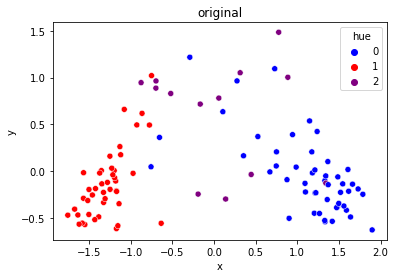

In [11]:
plot_embs(embs, y, title="original")

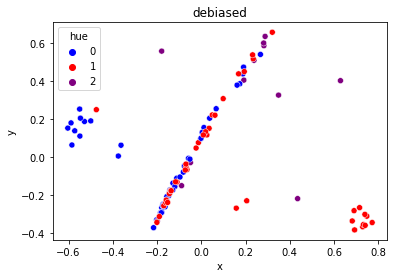

In [12]:
plot_embs(emb, y, title="debiased")